# Physics-informed neural network to solve 2D-2phase Poisson equation with piecewise smooth diffusivities

The Stokes equations are defined on a rectangular domain with an embedding circle, $\Gamma=\{(x,\,y)=r(\theta)(\cos\theta,\sin\theta)\:|\:r(\theta)=a+b\cos(k\theta)$, separating the domain into outer and inner regions, say $\Omega^+$ and $\Omega^-$, respectively. 

\begin{eqnarray}
-\nabla p({\bf x}) + \nabla\cdot\left(\mu({\bf x})\left(\nabla{\bf u}({\bf x})+\nabla{\bf u}^T({\bf x})\right)\right) + {\bf g}({\bf x}) & = & \mathbf{0}, \quad {\bf x}\in\Omega, \\
\nabla\cdot{\bf u}({\bf x}) & = & 0, \quad {\bf x}\in\Omega,\\
{\bf u} ({\bf x}) & = & {\bf u}_b({\bf x}), \quad {\bf x}\in\partial\Omega.\\
[p]_\Gamma = 2[\mu\partial_n{\bf u}\cdot{\bf n}] + F_p, && [{\bf u}]_\Gamma={\bf 0},\quad [\mu\partial_n{\bf u}\cdot{\bf \tau}]+[\mu\partial_\tau{\bf u}\cdot{\bf n}]+F_{\bf u} = 0
\end{eqnarray}

Method: DCSNN hybrid CuspNN


The sources for jump conditions are: 

\begin{eqnarray}
F_{N} &=& {\bf F}\cdot{\bf n}=\sigma\kappa \\
F_{T} &=& {\bf 0} 
\end{eqnarray}

### Import packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import functools
from pyDOE import lhs

from functorch import make_functional, vmap, grad, jacrev, hessian

from collections import namedtuple, OrderedDict
import datetime
import time
from IPython.display import clear_output 
from copy import deepcopy 

### Empty cache and check devices

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Problem setup

In [3]:
# domain [a,b]\times[c,d]
ba = - 2.
bb =   2.
bc = - 2.
bd =   2.
xw = bb - ba
yw = bd - bc
# for piecewise constant \beta
visi = 1.
viso = .5
vis_jmp = viso - visi
vis_sum = viso + visi
vismx   = np.amax([ visi , viso ])
# radii of the star-shaped interface: r(\theta) = alp + bta\cos(kw\theta)
alp = 1.0
bta = - 0.4
kw  = 3.
# Network size
n_input0 = 2
n_input  = n_input0 + 1    # with augmented feature
# number of testing points
N_tsd_final = 100000
N_tsb_final = 1000
N_tsg_final = 1000

### Exact solution, beta, source, and level set function

In [4]:
def levfun(x, y):
    thet = np.arctan2(y, x)
    rsq  = x*x + y*y
    thet_x  = - y/rsq
    thet_y  =   x/rsq
    rt   = alp + bta*np.cos(kw*thet)
    drt  = - (bta*kw)*np.sin(kw*thet)
    drt2 = - (bta*kw*kw)*np.cos(kw*thet)
    tp   = ( drt*drt + rt*drt2 )/rsq
    qo = rsq - rt*rt
    q  = np.zeros( (len(x),2) )
    q[:,0:1] = np.abs(qo)
    q[:,1:2] = np.sign(qo)
    qu = np.zeros( (len(x),5) )
    qu[:,1:2] = 2.*( x - rt*drt*thet_x )
    qu[:,2:3] = 2.*( y - rt*drt*thet_y )
    qu[:,4:5] = 4 - 2*tp
    for i in range(len(x)):
        if qo[i] <= 0.:
            qu[i,0] = visi
            qu[i,1:] = - qu[i,1:]   
        else:
            qu[i,0] = viso                
    qu[:,3:4] = qu[:,1:2] * qu[:,1:2] + qu[:,2:3] * qu[:,2:3]
    return qo, q, qu


def lvnorvec(x, y):
    thet = np.arctan2(y, x)
    rt   = alp + bta*np.cos(kw*thet)
    drt  = - (bta*kw)*np.sin(kw*thet)
    rsq  = x*x + y*y
    thet_x  = - y/rsq
    thet_y  =   x/rsq
    qx = 2.*( x - rt*drt*thet_x )
    qy = 2.*( y - rt*drt*thet_y )
    dqsqrt = np.sqrt( qx*qx + qy*qy )
    nv1 = qx/dqsqrt    # n1
    nv2 = qy/dqsqrt    # n2
    return nv1, nv2, dqsqrt


def exact_vis(x, y, z):
    vis  = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] <= 0.:
            vis[i] = visi
        else:
            vis[i] = viso
    return vis # , visx, visy


def jump_sources(x, y):
    thet = np.arctan2(y, x)
    rt   = alp + bta*np.cos(kw*thet)
    drt  = - (bta*kw)*np.sin(kw*thet)
    drt2 = - (bta*kw*kw)*np.cos(kw*thet)
    # curvature force
    Fn = ( rt*rt + 2*drt*drt - rt*drt2 )/((rt*rt+drt*drt)**1.5)
    Ft = np.zeros_like(Fn)
    return Fn, Ft


def jump_forces(x, y):
    Fn, Ft = jump_sources(x, y) 
    nv1, nv2, dqsqrt = lvnorvec(x, y)
    Fx = Fn*nv1 + Ft*nv2
    Fy = Fn*nv2 - Ft*nv1
    return 0.1*Fx, 0.1*Fy


### Test data set 

No. of interior  test data point: N_tsd_final = 100000
No. of boundary  test data point: N_tsb_final = 1000
No. of interface test data point: N_tsg_final = 1000
No. of overall   test data point: N_ts_total  = 102000


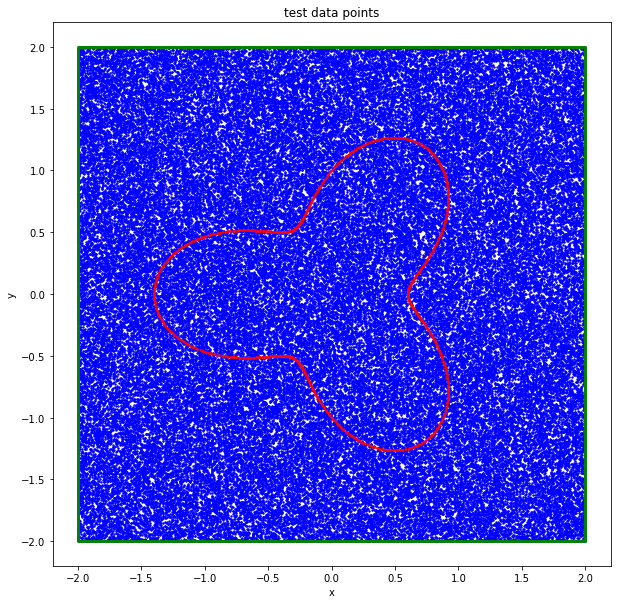

In [5]:
# No. of testing points
N_ts_final = N_tsd_final + N_tsb_final + N_tsg_final
print(f'No. of interior  test data point: N_tsd_final = {N_tsd_final}')
print(f'No. of boundary  test data point: N_tsb_final = {N_tsb_final}')
print(f'No. of interface test data point: N_tsg_final = {N_tsg_final}')
print(f'No. of overall   test data point: N_ts_total  = {N_ts_final}')

# fixed pseudo random generator
np.random.seed(777)

# interior test points
sampling = lhs(n_input0, N_tsd_final)
xd = ba + xw * sampling[:,0:1]
yd = bc + yw * sampling[:,1:2]
qdo, qd, qdu = levfun(xd, yd)
dqd = qdu[:,1:3]
X_tsd = np.hstack( ( xd , yd , qd ) )
Fd = np.hstack( ( qdu[:,0:1] , 2*qdu[:,1:3] , qdu[:,3:] ) )

# boundary test points
sampling = lhs(1, N_tsb_final)
xb = ba + xw * sampling
yb = bc + yw * sampling
Xb1 = np.hstack( ( ba * np.ones_like(yb) , yb ) )
Xb2 = np.hstack( ( bb * np.ones_like(yb) , yb ) )
Xb3 = np.hstack( ( xb , bc * np.ones_like(xb) ) )
Xb4 = np.hstack( ( xb , bd * np.ones_like(xb) ) )
X_tsb = np.vstack( ( Xb1 , Xb2 , Xb3 , Xb4 ) )
qbo, qb, qbu = levfun(X_tsb[:,0:1], X_tsb[:,1:2])
dqb = qbu[:,1:3]
X_tsb = np.hstack( ( X_tsb , qb ) )

# generate interfacial testing points
thet = 2*np.pi*( lhs(1, N_tsg_final) + lhs(1,1) )
rt = alp + bta*np.cos(kw*thet)
xg = rt * np.cos( thet )
yg = rt * np.sin( thet )
qg = np.hstack( ( np.zeros_like(thet) , np.ones_like( thet) ) )
Xg_ts_final = np.hstack( ( xg , yg , qg ) )
nv1g, nv2g, dphi_norm = lvnorvec(xg, yg)
Fg_ts_final = np.hstack( ( nv1g , nv2g , dphi_norm ) )

# combine all together
phi_ts_final = np.vstack( ( qdo , qbo ) )
Xd_ts_final  = np.vstack( ( X_tsd , X_tsb ) )
Fd_ts_final  = np.vstack( ( dqd , dqb ) )

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_tsd[:,0:1], X_tsd[:,1:2], s=2, c='b', cmap = "plasma") 
ax.scatter(X_tsb[:,0:1], X_tsb[:,1:2], s=2, c='g', cmap = "plasma")
ax.scatter(xg, yg, s=2, c='r', cmap = "plasma")
plt.xlabel('x')
plt.ylabel('y')
plt.title('test data points')

plt.show()

# tensor style 
Xd_ts_final = torch.tensor( Xd_ts_final ).double().to(device)
Fd_ts_final = torch.tensor( Fd_ts_final ).double().to(device)
Xg_ts_final = torch.tensor( Xg_ts_final ).double().to(device)
Fg_ts_final = torch.tensor( Fg_ts_final ).double().to(device)

### Define network: Shallow or Deep

In [6]:
class NeuralNet_Shallow(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    
    def __init__(self, in_dim , h_dim_uv , h_dim_p, out_dim_uv, out_dim_p):
        super(NeuralNet_Shallow, self).__init__()
        # network for uv
        self.ln1_uv  = nn.Linear( in_dim , h_dim_uv )
        self.act1_uv = nn.Sigmoid()
        self.ln2_uv  = nn.Linear( h_dim_uv , out_dim_uv , bias=False )
        # network for p
        self.ln1_p  = nn.Linear( in_dim , h_dim_p )
        self.act1_p = nn.Sigmoid()
        self.ln2_p  = nn.Linear( h_dim_p , out_dim_p , bias=False )
        
    def forward(self, x):
        # output for u and v
        out_uv = torch.hstack( ( x[0] , x[1] , x[2] ) )
        out_uv = self.ln1_uv(out_uv)
        out_uv = self.act1_uv(out_uv)
        out_uv = self.ln2_uv(out_uv)
        # output for p
        out_p = torch.hstack( ( x[0] , x[1] , x[3] ) )
        out_p = self.ln1_p(out_p)
        out_p = self.act1_p(out_p)
        out_p = self.ln2_p(out_p)
        # output
        out = torch.hstack( ( out_uv , out_p ) )
        return out

In [7]:
class NeuralNet_Deep(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim , h_dim_uv , h_dim_p , out_dim_uv , out_dim_p , depth ):
        super(NeuralNet_Deep, self).__init__()
        self.depth = depth - 1
        # u and v
        self.list_uv = nn.ModuleList()
        self.ln1_uv  = nn.Linear( in_dim , h_dim_uv )
        self.act1_uv = nn.Sigmoid()
        for i in range(self.depth):
            self.list_uv.append( nn.Linear( h_dim_uv , h_dim_uv ) )
        self.lnd_uv = nn.Linear( h_dim_uv , out_dim_uv , bias=False )
        # p
        self.list_p = nn.ModuleList()
        self.ln1_p  = nn.Linear( in_dim , h_dim_p )
        self.act1_p = nn.Sigmoid()
        for i in range(self.depth):
            self.list_p.append( nn.Linear( h_dim_p , h_dim_p ) )
        self.lnd_p = nn.Linear( h_dim_p , out_dim_p , bias=False )
        
        
    def forward(self, x):
        # u and v
        out_uv = torch.hstack( ( x[0] , x[1] , x[2] ) )
        out_uv = self.ln1_uv(out_uv)
        out_uv = self.act1_uv(out_uv)
        for i in range(self.depth):
            out_uv = self.list_uv[i](out_uv)
            out_uv = self.act1_uv(out_uv)
        out_uv = self.lnd_uv(out_uv)
        # p
        out_p = torch.hstack( ( x[0] , x[1] , x[3] ) )
        out_p = self.ln1_p(out_p)
        out_p = self.act1_p(out_p)
        for i in range(self.depth):
            out_p = self.list_p[i](out_p)
            out_p = self.act1_p(out_p)
        out_p = self.lnd_p(out_p)
        # output
        out = torch.hstack( ( out_uv , out_p ) )
        return out

### Essential nametuples in the model

In [8]:
DataInput = namedtuple( "DataInput" , [ "Xd" , "Fd" , "Xb" , "Fb" , "Xg" , "Fg" , "NL" , "NL_sqrt"] )
LM_Setup = namedtuple( "LM_Setup" , [ 'p_vec_o' , 'dp_o' , 'L_o' , 'J_o' , 'mu0' , 'criterion' ] )

### Data generator

In [9]:
def generate_data(iopt, Nd, Nb, Ng):
    
    ## Xd: points inside the domain (randomly)
    sampling = lhs(n_input0, Nd)
    xd = ba + xw * sampling[:,0:1]
    yd = bc + yw * sampling[:,1:2]
    qdo, qd, qdu = levfun(xd, yd)
    # remove points at the interface
    qid = np.where(np.abs(qdo)<5e-16)
    qd  = np.delete(qd, qid[0], 0)
    qdu = np.delete(qdu, qid[0], 0)
    xd  = np.delete(xd, qid[0], 0)
    yd  = np.delete(yd, qid[0], 0)
    qdo = np.delete(qdo, qid[0], 0) 
    Nd_new = len(qdo)
    # augmented input
    Xd = np.hstack( ( xd , yd , qd ) )
    # modify right hand side 
    Fd = np.hstack( ( qdu[:,0:1] , 2*qdu[:,1:3] , qdu[:,3:] , qdu[:,1:3] ) ) 
    
    ## Xb: points respond for boundary condition (randomly)
    col = np.ones((Nb,1))
    sampling = lhs(1, Nb)
    xb1 = np.hstack( ( ba*col , bc+yw*sampling ) )
    sampling = lhs(1, Nb)
    xb2 = np.hstack( ( bb*col , bc+yw*sampling ) )
    sampling = lhs(1, Nb)
    xb3 = np.hstack( ( ba+xw*sampling , bc*col ) )
    sampling = lhs(1, Nb)
    xb4 = np.hstack( ( ba+xw*sampling , bd*col ) )
    # combine 
    Xb = np.vstack( ( xb1 , xb2 , xb3 , xb4 ) )
    # augmented input
    qbo, qb, qbu = levfun(Xb[:,0:1], Xb[:,1:2])
    Xb = np.hstack( ( Xb , qb ) )
    # Boundary condition
    Fb = np.hstack( ( np.zeros_like(qbo) , np.zeros_like(qbo) ) )
    
    ## X_gma: points on the interface N_trg
    thet = 2*np.pi*( lhs(1, Ng) + lhs(1,1) )
    rt = alp + bta*np.cos(kw*thet)
    xg = rt * np.cos(thet)
    yg = rt * np.sin(thet)
    Xg  = np.hstack( ( xg , yg , np.zeros_like(thet) , np.ones_like(thet) ) )
    # normal vector along the interface
    nv1, nv2, dphi_norm = lvnorvec(xg, yg)
    # jump condition for velocity: Fx and Fy
    Fx_jp, Fy_jp = jump_forces(xg, yg)
    # combine all sources
    tmp = vis_sum * dphi_norm
    Fg  = np.hstack( ( tmp , nv1 , nv2 , vis_jmp*nv1 , vis_jmp*nv2 , tmp*nv1 , tmp*nv2, Fx_jp , Fy_jp ) )
        
    # size of each piece of loss
    NB = 4*Nb
    NL      = [3*Nd_new+2*NB+2*Ng, Nd_new, NB, Ng]
    NL_sqrt = np.sqrt(NL)
    
    ## plot the distribution of data
    if iopt != 0:
        #cfd = torch.sum(Fd*Fd)/NL[1]
        #cfb = torch.sum(Ub*Ub)/NL[2]
        #cfg = torch.sum(Fg[:,2:3]*Fg[:,2:3])/NL[3]
        print(f'No. of training points in the bulk domain: {Nd_new}')
        print(f'No. of training points at the outer boundary: {NB}')
        print(f'No. of training points at the interface: {Ng}')
        plt.figure(figsize = (10,10))
        plt.scatter(Xd[:,0:1], Xd[:,1:2], c = "b", s = 10, marker = ".") 
        plt.scatter(Xb[:,0:1], Xb[:,1:2], c = "r", s = 40, marker = ".")
        plt.scatter(Xg[:,0:1], Xg[:,1:2], c = "k", s = 60, marker = ".")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis('equal')
        plt.title('training points')
        plt.show()
        
    # torch tensor
    Xd = torch.tensor(Xd, requires_grad=True).double().to(device)
    Fd = torch.tensor(Fd).double().to(device)
    Xb = torch.tensor(Xb, requires_grad=True).double().to(device)
    Fb = torch.tensor(Fb).double().to(device)
    Xg = torch.tensor(Xg, requires_grad=True).double().to(device)
    Fg = torch.tensor(Fg).double().to(device)
 
    return Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt 

### Components of loss

In [10]:
# compute the interior loss
def func_lsd(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model_uv_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u, v, p wrt inputs
    df   = jacrev(f)(pts, func_params)
    d2f  = jacrev(jacrev(f))(pts, func_params)
    lsdu = d2f[0][0][0] + d2f[0][1][1] + fd[1]*d2f[0][0][2] + fd[2]*d2f[0][1][2] + fd[3]*d2f[0][2][2] \
            + fd[4]*df[0][2] - df[2][0]/fd[0]
    lsdv = d2f[1][0][0] + d2f[1][1][1] + fd[1]*d2f[1][0][2] + fd[2]*d2f[1][1][2] + fd[3]*d2f[1][2][2] \
            + fd[4]*df[1][2] - df[2][1]/fd[0]
    lsdp = df[0][0] + df[1][1] + fd[5]*df[0][2] + fd[6]*df[1][2]
    return lsdu/udmsesqrt, lsdv/vdmsesqrt, lsdp


# compute the boundary loss 
def func_lsb(func_params, pts, fb):
    def f(x, func_params):
        fx = func_model_uv_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # function value at the boundary (Dirichlet boundary condition)
    fval = f(pts, func_params)
    lsbu = fval[0] - fb[0]
    lsbv = fval[1] - fb[1]
    return lsbu/ubmsesqrt, lsbv/vbmsesqrt


# compute the interfacial loss
def func_lsg(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model_uv_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u and v
    df = jacrev(f)(pts, func_params)
    # jump of p
    ptsn = torch.hstack( ( pts[0] , pts[1] , pts[2] , -pts[3] ) )
    pp = f(pts, func_params)[2]
    pn = f(ptsn, func_params)[2]
    p_jp = pp - pn
    # jump of u and v
    tp0 = fg[1]*df[0][2] + fg[2]*df[1][2] 
    tp1 = df[0][1] + df[1][0]
    lsgu = fg[7] - p_jp*fg[1] + 2*df[0][0]*fg[3] + tp1*fg[4] + df[0][2]*fg[0] + tp0*fg[5] 
    lsgv = fg[8] - p_jp*fg[2] + 2*df[1][1]*fg[4] + tp1*fg[3] + df[1][2]*fg[0] + tp0*fg[6]  
    return lsgu/ugmsesqrt, lsgv/vgmsesqrt

In [11]:
def func_pred_uvp(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model_uv_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # prediction
    fval = f(pts, func_params)
    u_pred = fval[0]
    v_pred = fval[1]
    p_pred = fval[2]
    # derivatives of f wrt inputs
    df = jacrev(f)(pts, func_params)
    ux_pred  = df[0][0]
    uz_pred  = df[0][2]
    vy_pred  = df[1][1]
    vz_pred  = df[1][2]
    div_pred = ux_pred + vy_pred + fd[0]*uz_pred + fd[1]*vz_pred
    return u_pred, v_pred, p_pred, div_pred # px_pred, py_pred 


def func_pred_duvn(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model_uv_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # interfacial part
    df = jacrev(f)(pts, func_params)
    ux_pred = df[0][0]
    uy_pred = df[0][1]
    uz_pred = df[0][2]
    vx_pred = df[1][0]
    vy_pred = df[1][1]
    vz_pred = df[1][2]
    tpu  = ux_pred*fg[0] + uy_pred*fg[1]
    tpux = uz_pred*fg[2]
    tpv  = vx_pred*fg[0] + vy_pred*fg[1]
    tpvx = vz_pred*fg[2]
    dupn_pred = tpu + tpux
    dunn_pred = tpu - tpux
    dvpn_pred = tpv + tpvx
    dvnn_pred = tpv - tpvx
    return dupn_pred, dunn_pred, dvpn_pred, dvnn_pred

### Levenberg-Marquardt (LM) optimizer

In [12]:
# parameters counter
def count_parameters(func_params):
    return sum(p.numel() for p in func_params if p.requires_grad)

In [13]:
# get the model's parameter
def get_p_vec(func_params):
    p_vec = []
    cnt = 0
    for p in func_params:
        p_vec = p.contiguous().view(-1) if cnt == 0 else torch.cat([p_vec, p.contiguous().view(-1)])
        cnt = 1 
    return p_vec

In [14]:
# Initialization of LM method
def generate_initial_LM(func_params, data_length):
    
    # p_vector
    with torch.no_grad():
        p_vec_old = get_p_vec(func_params).double().to(device)
    
    # dp
    dp_old = torch.zeros( [ count_parameters(func_params) , 1 ] ).double().to(device)

    # Loss
    L_old = torch.zeros( [ data_length , 1 ] ).double().to(device)
    
    # Jacobian
    J_old = torch.zeros( [ data_length , count_parameters(func_params) ] ).double().to(device)
    
    return p_vec_old, dp_old, L_old, J_old

In [15]:
def train_PINNs_uv_p_LM(func_params, LM_setup, tr_input, ts_input, lossval, lossval_ts):
    
    # assign tuple elements of LM_set_up
    p_vec_o, dp_o, L_o, J_o, mu, criterion = LM_setup
    I_pvec = torch.eye(len(p_vec_o)).to(device)
    
    # assign tuple elements of data_input 
    [Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt] = tr_input
    [Xd_ts, Fd_ts, Xb_ts, Fb_ts, Xg_ts, Fg_ts, NL_ts, NL_sqrt_ts] = ts_input
    
    ### computation of loss
    Ldu, Ldv, Ldp = vmap((func_lsd), (None, 0, 0))(func_params, Xd, Fd)
    Lbu, Lbv      = vmap((func_lsb), (None, 0, 0))(func_params, Xb, Fb)
    Lgu, Lgv      = vmap((func_lsg), (None, 0, 0))(func_params, Xg, Fg)
    L = torch.cat( ( torch.cat( ( Ldu , Ldv , Ldp ) )/NL_sqrt[1] , \
                     torch.cat( ( Lbu , Lbv ) )/NL_sqrt[2] , \
                     torch.cat( ( Lgu , Lgv ) )/NL_sqrt[3] ) )
    L = L.reshape(NL[0],1).detach()
    lsd_sum = torch.sum( Ldu**2 + Ldv**2 + Ldp**2 ) / NL[1]
    lsb_sum = torch.sum( Lbu**2 + Lbv**2 ) / NL[2] 
    lsg_sum = torch.sum( Lgu**2 + Lgv**2 ) / NL[3]
    ls_sum  = lsd_sum + lsb_sum + lsg_sum
    lossval[0,:] = [0, lsd_sum.item(), lsb_sum.item(), lsg_sum.item(), ls_sum.item()]
    
    # iteration counts and check
    func_params_best = deepcopy(func_params)
    loss_best  = np.ones((2,1)).reshape((2))
    ts_over_tr = ts_over_tr_tol
    step       = 0
    step_ts    = 0
    loss_now   = ls_sum.item()
    
    # try-except statement to avoid jam in the code
    try:
        while (loss_now>tol_main1 or ts_over_tr>=100.) and (step<=tr_iter_max):
            
            torch.cuda.empty_cache()
            
            ### compute the gradinet of loss function for each point
            with torch.no_grad():
                p_vec = get_p_vec(func_params).detach() # get p_vec for p_vec_old if neccessary 
        
            if criterion:
                gdu, gdv, gdp = vmap(jacrev(func_lsd), (None, 0, 0))(func_params, Xd, Fd)
                cnt = 0
                for g in gdu: 
                    g = g.detach()
                    Ju_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Ju_d,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdv: 
                    g = g.detach()
                    Jv_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jv_d,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdp: 
                    g = g.detach()
                    Jp_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jp_d,g.reshape(len(g),-1)])
                    cnt = 1

                gdu, gdv = vmap(jacrev(func_lsb), (None, 0, 0))(func_params, Xb, Fb)
                cnt = 0
                for g in gdu: 
                    g = g.detach()
                    Ju_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Ju_b,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdv: 
                    g = g.detach()
                    Jv_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jv_b,g.reshape(len(g),-1)])
                    cnt = 1
                    
                gdu, gdv = vmap(jacrev(func_lsg), (None, 0, 0))(func_params, Xg, Fg)
                cnt = 0
                for g in gdu: 
                    g = g.detach()
                    Ju_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Ju_g,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdv: 
                    g = g.detach()
                    Jv_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jv_g,g.reshape(len(g),-1)])
                    cnt = 1
                
                J = torch.cat( ( torch.cat( ( Ju_d , Jv_d , Jp_d ) )/NL_sqrt[1] , \
                                 torch.cat( ( Ju_b , Jv_b ) )/NL_sqrt[2] , \
                                 torch.cat( ( Ju_g , Jv_g ) )/NL_sqrt[3] ) ).detach()
                
                ### info. normal equation of J
                J_product = J.t()@J
                rhs       = - J.t()@L
                 
                    
            with torch.no_grad():
                ### solve the linear system
                dp  = torch.linalg.solve( J_product + mu*I_pvec , rhs )
                cnt = 0
                for p in func_params:
                    mm   = torch.Tensor([p.shape]).tolist()[0]
                    num  = int( functools.reduce( lambda x,y : x*y, mm, 1 ) )
                    p   += dp[cnt:cnt+num].reshape(p.shape)
                    cnt += num
            
            ### Compute loss_new    
            Ldu, Ldv, Ldp = vmap((func_lsd), (None, 0, 0))(func_params, Xd, Fd)
            Lbu, Lbv      = vmap((func_lsb), (None, 0, 0))(func_params, Xb, Fb)
            Lgu, Lgv      = vmap((func_lsg), (None, 0, 0))(func_params, Xg, Fg)
            L = torch.cat( ( torch.cat( ( Ldu , Ldv , Ldp ) )/NL_sqrt[1] , \
                             torch.cat( ( Lbu , Lbv ) )/NL_sqrt[2] , \
                             torch.cat( ( Lgu , Lgv ) )/NL_sqrt[3] ) )
            L = L.reshape(NL[0],1).detach()
            loss_new = torch.sum(L*L).item()
            lsd_sum = torch.sum( Ldu**2 + Ldv**2 + Ldp**2 )/NL[1]
            lsb_sum = torch.sum( Lbu**2 + Lbv**2)/NL[2]
            lsg_sum = torch.sum( Lgu**2 + Lgv**2)/NL[3]
                   
            # strategy to update mu
            if ( step > 0 ):
                
                with torch.no_grad():
             
                    # accept update 
                    if loss_new < loss_now:
                        p_vec_old  = p_vec.detach()
                        dp_old     = dp
                        L_old      = L
                        J_old      = J
                        mu         = max( mu/mu_div , tol_machine )
                        criterion  = True #False
                        lossval[step,:] = [step, lsd_sum.item(), lsb_sum.item(), lsg_sum.item(), loss_new]
                        loss_now = loss_new
                    
                    else:
                        cosine = nn.functional.cosine_similarity(dp, dp_old, dim=0, eps=1e-15)
                        cosine_check = (1.-cosine)*loss_new > min(lossval[0:step-1,-1]) 
                        if cosine_check: # give up the direction
                            cnt=0
                            for p in func_params:
                                mm   = torch.Tensor([p.shape]).tolist()[0]
                                num  = int( functools.reduce(lambda x,y: x*y, mm, 1) )
                                p   -= dp[cnt:cnt+num].reshape(p.shape)
                                cnt += num
                            mu = min( mu_mul*mu , mu_max )
                            criterion  = False
                        else: # accept 
                            p_vec_old = p_vec.detach()
                            dp_old    = dp 
                            L_old     = L
                            J_old     = J
                            mu        = max( mu/mu_div , tol_machine )       
                            criterion  = True
                        lossval[step,0] = step
                        lossval[step,1:] = lossval[step-1,1:]
            
            else:   # for old info. 
       
                with torch.no_grad():
              
                    p_vec_old  = p_vec.detach()
                    dp_old     = dp
                    L_old      = L
                    J_old      = J
                    mu         = max( mu/mu_div , tol_machine )
                    criterion  = True
                    lossval[step,:] = [step, lsd_sum.item(), lsb_sum.item(), lsg_sum.item(), loss_new]
                    loss_now = loss_new

            
            # generate new testing data point
            if step % ts_input_new == 0:
                Xd_ts, Fd_ts, Xb_ts, Fb_ts, Xg_ts, Fg_ts, NL_ts, NL_sqrt_ts = generate_data(0, N_tsd, N_tsb, N_tsg)
                ts_input = DataInput(Xd=Xd_ts, Fd=Fd_ts, Xb=Xb_ts, Fb=Fb_ts, Xg=Xg_ts, Fg=Fg_ts, NL=NL_ts, NL_sqrt=NL_sqrt_ts)
                Xd_ts, Fd_ts, Xb_ts, Fb_ts, Xg_ts, Fg_ts, NL_ts, NL_sqrt_ts = ts_input
                print(f'Pass renew testing points at step {step}!')
            
                # compute testing loss
                Ldu_ts, Ldv_ts, Ldp_ts = vmap((func_lsd), (None, 0, 0))(func_params, Xd_ts, Fd_ts)
                Lbu_ts, Lbv_ts         = vmap((func_lsb), (None, 0, 0))(func_params, Xb_ts, Fb_ts)
                Lgu_ts, Lgv_ts         = vmap((func_lsg), (None, 0, 0))(func_params, Xg_ts, Fg_ts)
                Lts = torch.cat( ( torch.cat( ( Ldu_ts , Ldv_ts , Ldp_ts ) )/NL_sqrt_ts[1] , \
                                   torch.cat( ( Lbu_ts , Lbv_ts ) )/NL_sqrt_ts[2] , \
                                   torch.cat( ( Lgu_ts , Lgv_ts ) )/NL_sqrt_ts[3] ) )
                Lts     = Lts.reshape(NL_ts[0], 1).detach()
                Lts_sum = torch.sum(Lts**2).item()
                lsd_sum = torch.sum( Ldu_ts**2 + Ldv_ts**2 + Ldp_ts**2 )/NL_ts[1]
                lsb_sum = torch.sum( Lbu_ts**2 + Lbv_ts**2 )/NL_ts[2]
                lsg_sum = torch.sum( Lgu_ts**2 + Lgv_ts**2 )/NL_ts[3]
                lossval_ts[step_ts,:] = [step, lsd_sum.item(), lsb_sum.item(), lsg_sum.item(), Lts_sum]
                step_ts += 1
                
                ts_over_tr = Lts_sum/loss_now

                print("Step %s: " % (step) )
                print(f" training loss: {loss_now:.4e}")
                print(f" testing loss : {Lts_sum:.4e}")
                print(f" L_ts/L_tr: {ts_over_tr:.4e}")
                print(f" mu: {mu}")
                
                if ( ts_over_tr < 10. ):
                    loss_best[0] = loss_now
                    loss_best[1] = Lts_sum
                    func_params_best = deepcopy(func_params)
                   
            step += 1
        
        lossval[-1,-1] = loss_now
        lossval_ts[-1,-1] = Lts_sum
        print("Step %s: " % (step-1) )
        print(f" training loss: {lossval[-1,-1]:.4e}")
        print(f" testing loss : {lossval_ts[-1,-1]:.4e}")
        print(f" L_ts/L_tr: {ts_over_tr:.4e}")
        print(f" mu: {mu}")
        print('finished')
        return lossval, lossval_ts, func_params_best, loss_best
    
    except KeyboardInterrupt:
        print('interpret')
        print(step)
        return lossval, lossval_ts, func_params_best, loss_best

### Main procedures

U & V: No. of input 3, hidden layer 1 (80 neurons each layer) and output 2
P: No. of input 3, hidden layer 1 (60 neurons each layer) and output 1
No. of total trainable parameters:780
NeuralNet_Shallow(
  (ln1_uv): Linear(in_features=3, out_features=80, bias=True)
  (act1_uv): Sigmoid()
  (ln2_uv): Linear(in_features=80, out_features=2, bias=False)
  (ln1_p): Linear(in_features=3, out_features=60, bias=True)
  (act1_p): Sigmoid()
  (ln2_p): Linear(in_features=60, out_features=1, bias=False)
)
No. of training points in the bulk domain: 2500
No. of training points at the outer boundary: 200
No. of training points at the interface: 150


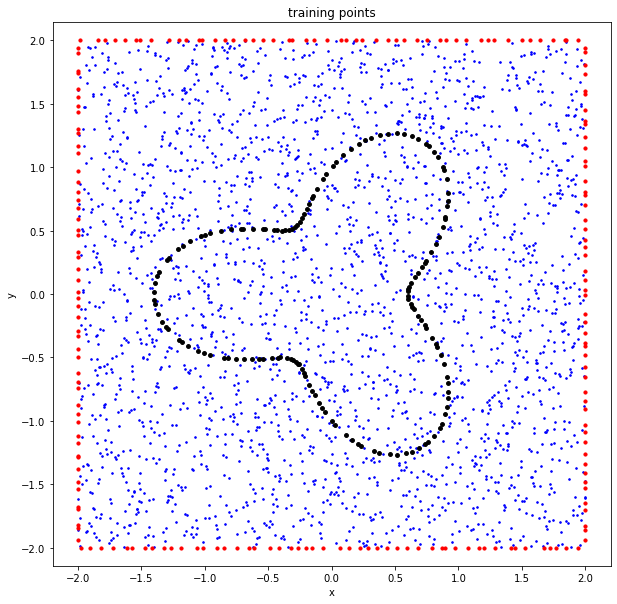

tensor(0.1830)
tensor(0.1854)
Pass renew testing points at step 0!
Step 0: 
 training loss: 5.1311e+01
 testing loss : 4.8091e+01
 L_ts/L_tr: 9.3723e-01
 mu: 83333333.33333334
Pass renew testing points at step 500!
Step 500: 
 training loss: 5.8928e-02
 testing loss : 6.1469e-01
 L_ts/L_tr: 1.0431e+01
 mu: 5.074638772855545e-05
Pass renew testing points at step 1000!
Step 1000: 
 training loss: 3.9913e-02
 testing loss : 3.9176e+01
 L_ts/L_tr: 9.8152e+02
 mu: 4.5368168530762394e-05
interpret
1314
total time : 0:24:16.009972
Training loss and test loss:
Loss_tr = 0.00e+00
Loss_ts = 0.00e+00
U & V: No. of input 3, hidden layer 1 (80 neurons each layer) and output 2
P: No. of input 3, hidden layer 1 (60 neurons each layer) and output 1
No. of total trainable parameters:780
NeuralNet_Shallow(
  (ln1_uv): Linear(in_features=3, out_features=80, bias=True)
  (act1_uv): Sigmoid()
  (ln2_uv): Linear(in_features=80, out_features=2, bias=False)
  (ln1_p): Linear(in_features=3, out_features=60, bi

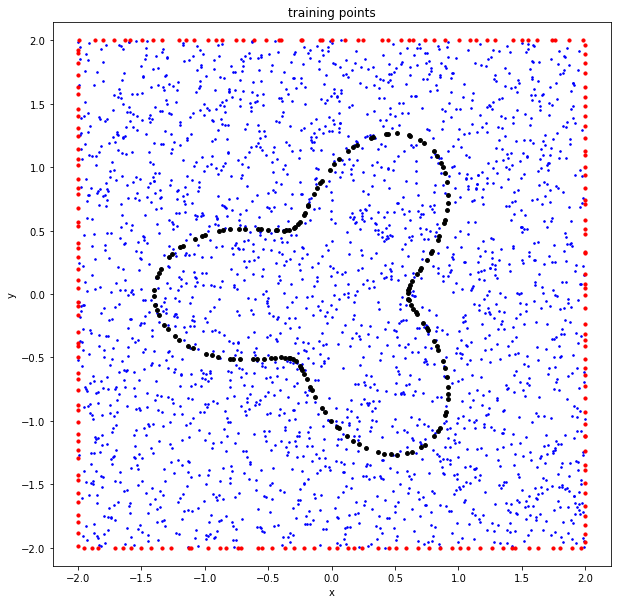

tensor(0.1798)
tensor(0.1873)
Pass renew testing points at step 0!
Step 0: 
 training loss: 3.4673e+02
 testing loss : 1.9922e+01
 L_ts/L_tr: 5.7456e-02
 mu: 83333333.33333334
interpret
5



KeyboardInterrupt



In [16]:
# create names for storages
fname = 'ex2D_Ex3_eta10_FXY_Sp30u50M1110'
char_id = ['a'] #,'b','c','d','e'] #,'f','g','h','i','j']

# tolerence for LM
tol_main1   = 1e-14
tol_main2   = 1e-15
tol_machine = 1e-15
mu_max      = 10**8
mu_ini      = 10**8
mu_mul      = 2.
mu_div      = 1.2
# iteration counts and check
tr_iter_max    = 3000                      # max. iteration
ts_input_new   = 500                       # renew testing points 
ts_over_tr_tol = 100.
# Network size
n_h_uv = 80
n_h_p  = 60
n_o_uv = 2
n_o_p  = 1
n_depth = 1 # only used in deep NN
# number of training points and testing points
c_addpt = 1.
M0 = 50
N_trd = M0*M0
N_trb = M0
N_trg = 3*M0
N_tsd = int(c_addpt*N_trd)
N_tsb = int(c_addpt*N_trb)
N_tsg = int(c_addpt*N_trg)

# relative errors and losses
relerr_loss = []

for char in char_id:
    
    # file name
    fname_char = fname+char 

    torch.cuda.empty_cache()
    
    # NN structure
    if n_depth == 1:   # Shallow NN
        model_uv_p = NeuralNet_Shallow(n_input, n_h_uv, n_h_p, n_o_uv, n_o_p).double().to(device)
        N_totpar = n_h_uv * ( n_input + n_o_uv + 1 ) + n_h_p * ( n_input + n_o_p + 1 )
    else:   # Deep NN
        model_uv_p = NeuralNet_Deep(n_input, n_h_uv, n_h_p, n_o_uv, n_o_p, n_depth).double().to(device)
        N_totpar = n_h_uv * ( (n_input+n_o_uv+1) + (n_depth-1)*n_h_uv ) + \
                   n_h_p * ( (n_input+n_o_p+1) + (n_depth-1)*n_h_p )
    print(f"U & V: No. of input {n_input}, hidden layer {n_depth} ({n_h_uv} neurons each layer) and output {n_o_uv}")
    print(f"P: No. of input {n_input}, hidden layer {n_depth} ({n_h_p} neurons each layer) and output {n_o_p}")
    print(f'No. of total trainable parameters:{N_totpar}')    
    
    # use Pytorch and functorch
    func_model_uv_p, func_params_uv_p = make_functional(model_uv_p)
    print(model_uv_p)
    
    # generate training data
    Xd_tr, Fd_tr, Xb_tr, Fb_tr, Xg_tr, Fg_tr, NL_tr, NL_sqrt_tr = generate_data(1, N_trd, N_trb, N_trg)
    tr_input = DataInput(Xd=Xd_tr, Fd=Fd_tr, Xb=Xb_tr, Fb=Fb_tr, Xg=Xg_tr, Fg=Fg_tr, NL=NL_tr, NL_sqrt=NL_sqrt_tr)
    udmsesqrt = 1. #torch.sqrt( torch.sum(Fd_tr[:,5:6]**2)/N_trd )
    vdmsesqrt = 1. #torch.sqrt( torch.sum(Fd_tr[:,6:7]**2)/N_trd )
    ubmsesqrt = 1. #torch.sqrt( torch.sum(Fb_tr[:,0:1]**2)/N_trb )
    vbmsesqrt = 1. #torch.sqrt( torch.sum(Fb_tr[:,1:2]**2)/N_trb )
    ugmsesqrt = torch.sqrt( torch.sum(Fg_tr[:,7:8]**2)/N_trg )
    vgmsesqrt = torch.sqrt( torch.sum(Fg_tr[:,8:9]**2)/N_trg )
    print(ugmsesqrt)
    print(vgmsesqrt)
    
    # generate testing data
    Xd_ts, Fd_ts, Xb_ts, Fb_ts, Xg_ts, Fg_ts, NL_ts, NL_sqrt_ts = generate_data(0, N_tsd, N_tsb, N_tsg)
    ts_input = DataInput(Xd=Xd_ts, Fd=Fd_ts, Xb=Xb_ts, Fb=Fb_ts, Xg=Xg_ts, Fg=Fg_ts, NL=NL_ts, NL_sqrt=NL_sqrt_ts)
        
    # initialization of LM
    p_vec_old, dp_old, L_old, J_old = generate_initial_LM(func_params_uv_p, NL_tr[0])
        
    # LM_setup
    mu = 10**(8)
    criterion = True
    LM_setup = LM_Setup( p_vec_o=p_vec_old , dp_o=dp_old , L_o=L_old , J_o=J_old , mu0=mu , criterion=criterion )

    # allocate loss
    lossval         = np.zeros((tr_iter_max+1,5))
    lossval_ts      = np.zeros(((int(tr_iter_max/ts_input_new)+1),5))

    # start the timer
    cnt_start = time.time()

    # train the model by LM optimizer
    lossval, lossval_ts, func_params_uv_p_best, loss_best = train_PINNs_uv_p_LM(func_params_uv_p, 
                                                            LM_setup, tr_input, ts_input, lossval, lossval_ts)
    
    end_start = time.time()
    total_T = str(datetime.timedelta(seconds=end_start-cnt_start))
    print(f"total time : {total_T}")
    
    print(f"Training loss and test loss:")
    print(f"Loss_tr = {lossval[-1,-1]:.2e}")
    print(f"Loss_ts = {lossval_ts[-1,-1]:.2e}")
    
    np.savetxt('fig_'+fname_char+'_loss_tr.txt',lossval)

    
    ########## relative errors and losses
    u, v, p, div = vmap((func_pred_uvp),(None,0,0))(func_params_uv_p,  Xd_ts_final, Fd_ts_final)
    dupn, dunn, dvpn, dvnn = vmap((func_pred_duvn),(None,0,0))(func_params_uv_p, Xg_ts_final, Fg_ts_final)
    
    u = u.detach().numpy()
    v = v.detach().numpy()
    p = p.detach().numpy()
    dupn = dupn.detach().numpy()
    dunn = dunn.detach().numpy()
    dvpn = dvpn.detach().numpy()
    dvnn = dvnn.detach().numpy()
    
#     abserrdupn = np.abs( dupn - ref_dupn_ts.flatten() )
#     abserrdunn = np.abs( dunn - ref_dunn_ts.flatten() )
#     abserrdvpn = np.abs( dvpn - ref_dvpn_ts.flatten() )
#     abserrdvnn = np.abs( dvnn - ref_dvnn_ts.flatten() )
    
#     abserrdiv  = np.linalg.norm(div.detach().numpy(), np.inf)

#     print(f"")
#     print(f"Divengence:")
#     print(f"L_inf norm of u_x+v_y: {abserrdiv: .2e}")
    
#     print(f"")
#     print(f"Error p: ")
#     abserrp_inf = np.linalg.norm(abserrp, np.inf)
#     abserrp_L2  = np.linalg.norm(abserrp, 2)
#     relerrp_inf = abserrp_inf / ref_p_ts_infnorm
#     relerrp_L2  = abserrp_L2  / ref_p_ts_L2norm
#     print(f" Max. err. = {abserrp_inf:.2e}; L_inf relerr. = {relerrp_inf:.2e}; L_2 relerr. = {relerrp_L2:.2e}")    
    
#     print(f"")
#     print(f"Error u: ")
#     abserru_inf = np.linalg.norm(abserru, np.inf)
#     abserru_L2  = np.linalg.norm(abserru, 2)
#     relerru_inf = abserru_inf / ref_u_ts_infnorm
#     relerru_L2  = abserru_L2  / ref_u_ts_L2norm
#     print(f" Max. err. = {abserru_inf:.2e}; L_inf relerr. = {relerru_inf:.2e}; L_2 relerr. = {relerru_L2:.2e}")
    
#     print(f"")
#     print(f"Error v: ")
#     abserrv_inf = np.linalg.norm(abserrv, np.inf)
#     abserrv_L2  = np.linalg.norm(abserrv, 2)
#     relerrv_inf = abserrv_inf / ref_v_ts_infnorm
#     relerrv_L2  = abserrv_L2  / ref_v_ts_L2norm
#     print(f" Max. err. = {abserrv_inf:.2e}; L_inf relerr. = {relerrv_inf:.2e}; L_2 relerr. = {relerrv_L2:.2e}")

# #     print(f"")
# #     print(f"Error of derivatives along normal:")
# #     abserrdupnmx = np.linalg.norm(abserrdupn, np.inf)
# #     abserrdunnmx = np.linalg.norm(abserrdunn, np.inf) 
# #     abserrdvpnmx = np.linalg.norm(abserrdvpn, np.inf) 
# #     abserrdvnnmx = np.linalg.norm(abserrdvnn, np.inf)
# #     relerrdupn_inf = abserrdupnmx / ( ref_dupn_ts_infnorm + 1e-8 )
# #     relerrdunn_inf = abserrdunnmx / ( ref_dunn_ts_infnorm + 1e-8 )
# #     relerrdvpn_inf = abserrdvpnmx / ( ref_dvpn_ts_infnorm + 1e-8 )
# #     relerrdvnn_inf = abserrdvnnmx / ( ref_dvnn_ts_infnorm + 1e-8 )
# #     print(f"Max.  abserr. dupn = {abserrdupnmx:.2e}; max. dupn = {ref_dupn_ts_infnorm:.2e}")
# #     print(f"Max.  abserr. dunn = {abserrdunnmx:.2e}; max. dunn = {ref_dunn_ts_infnorm:.2e}")
# #     print(f"Max.  abserr. dvpn = {abserrdvpnmx:.2e}; max. dvpn = {ref_dvpn_ts_infnorm:.2e}")
# #     print(f"Max.  abserr. dvnn = {abserrdvnnmx:.2e}; max. dvnn = {ref_dvnn_ts_infnorm:.2e}")
# #     print(f"")
#     print(f"")
#     print(f"")
#     relerr_loss_k = [abserrp_inf, relerrp_inf, relerrp_L2, \
#                      abserru_inf, relerru_inf, relerru_L2, \
#                      abserrv_inf, relerrv_inf, relerrv_L2, \
# #                      abserrdupnmx, relerrdupn_inf, abserrdunnmx, relerrdunn_inf, \
# #                      abserrdvpnmx, relerrdvpn_inf, abserrdvnnmx, relerrdvnn_inf, \
#                      abserrdiv, lossval[-1,-1], lossval_ts[-1,-1]]
    
#     relerr_loss.append(relerr_loss_k)

# np.savetxt('tab_'+fname+'_FXY_5runs.txt',relerr_loss)

In [ ]:
# plot evolution of loss
plt.figure(figsize = (10,10))

plt.semilogy(lossval[:,0:1], lossval[:,4:5])
plt.semilogy(lossval_ts[:,0:1], lossval_ts[:,4:5])
plt.semilogy(lossval[:,0:1], lossval[:,1:2])
plt.semilogy(lossval[:,0:1], lossval[:,2:3])
plt.semilogy(lossval[:,0:1], lossval[:,3:4])
plt.legend(['loss_tr', 'loss_ts' , 'loss_d', 'loss_b', 'loss_g'], loc='upper right')
plt.title('loss')